# Taiwanese PERM data anaylsis

### What is PERM?
PERM is the process for obtaining permanent labor certification from Department of Lobor, it is the first step of the green card process for foreign nationals seeking permanent residence through their employment.

The filing of applications is the responsibility of the employer, not the employee. The process is for DoL to ensure that the admission of foreign workers to work in the U.S. will not adversely affect the job opportunities, wages and working conditions of U.S. workers.

### Where does the data come from?

Using Python to scrape data from __[Visadoor](http://visadoor.com)__. Scrape only cases that the petition beneficiary is Taiwanese. See the web scraping code __[here](https://github.com/ktc312/tw_perm_data_analysis_web/blob/master/tw_perm_data_analysis/download_data.py)__.

---

# Read and Clean the data

In [1]:
import pandas as pd
import numpy as np

# Data from Otc, 2007 to  Mar, 2017
perm_df = pd.read_csv('TW_PERM.csv', parse_dates=['Decision_Date'])
perm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 7 columns):
id               8975 non-null object
Decision_Date    8975 non-null datetime64[ns]
Employer         8975 non-null object
City_State       8975 non-null object
Case_Status      8975 non-null object
Job_Title        8947 non-null object
Wage_Offer       8975 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 490.9+ KB


In [2]:
perm_df = perm_df.rename(columns={'Decision_Date': 'Date', 'Case_Status': 'Status'})
perm_df.head()

,id,Date,Employer,City_State,Status,Job_Title,Wage_Offer
0,A-16146-14510,2017-02-01,Sandisk Corporation,"Milpitas, CA",Certified,"Electronics Engineers, Except Computer, Level II","122,672.00/Year"
1,A-16263-53960,2017-01-11,"Ooyala, Inc.","Santa Clara, CA",Certified,"Software Developers, Systems Software, Level II","125,000.00/Year"
2,A-16123-04570,2016-11-15,"Baily International, Inc.","HOUSTON, TX",Certified,"BUSINESS DEVELOPMENT ANALYST, Level I",37378/Year
3,A-15091-63241,2016-09-30,"Netapp, Inc.","Cranberry Township, PA",Certified,"Software Developers, Systems Software, Level II","74,568.00/Year"
4,A-16159-18555,2016-09-30,"Hauptman Ham, Llp","Alexandra, VA",Certified,"Paralegals and Legal Assistants, Level III","108,909.00/Year"


In [3]:
# clean the data, column by column

# Drop id
perm = perm_df.drop('id', axis=1)

# Sort by date
perm = perm.sort_values(['Date'], ascending=False)

# Employer name
original_counts = perm.Employer.str.lower().value_counts() 

display(pd.DataFrame(original_counts.head()))

,Employer
intel corporation,209
microsoft corporation,137
google inc.,77
"super micro computer, inc.",65
broadcom corporation,56


In [4]:
# edit employer name to operating name of a company, as opposed to the legal name of the company (dba)
perm.loc[perm.Employer.str.lower().str.contains(' dba '), 'Employer'] = perm.Employer          \
                                                                            .str.lower()       \
                                                                            .str.split(' dba ')\
                                                                            .str[1]

# edit employer name to same format
edit_list = ['oracle', 'qualcomm', 'formosa plastics', 'amazon', 'tsmc',
             'texas instrument', 'nan ya plastics', 'foxconn', 'pricewaterhousecoopers',
             'world journal', 'pacpizza', 'hewlett-packard', 'muy pizza', 'ernst & young', 
             'acme furniture', 'air sea transport', 'appleseed', 'au optronics', 'bank sinopac', 
             'american future technology', 'yang ming america', 'paradigm', 'paragi']  
for name in edit_list: 
    perm.loc[perm.Employer.str.lower().str.startswith(name), 'Employer'] = name


# remove unnecessary characters
replace_list = [',', '!', '.', ' inc', ' llc', ' llp', ' ltd', ' lp', 
                ' corporation', ' corporate', ' corp', ' technologies'] 
for char in replace_list: 
    perm.Employer = perm.Employer.str.lower().str.replace(char, '')  

# edit typo
perm.Employer = perm.Employer                                                              \
                    .str.lower()                                                           \
                    .str.replace('buisness', 'business')                                   \
                    .str.replace('cisco-linksys', 'cisco systems')                         \
                    .str.replace('apple computer', 'apple')                                \
                    .str.replace('appleseed', 'appleseed international montessori school') \
                    .str.replace('sutech industry a division of foxconn', 'foxconn')       \
                    .str.replace('paradigm', 'Paradigm Health & Wellness')                 \
                    .str.replace('paragi', 'Paradigm Health & Wellness')                   \
                    .str.replace('uni pac continental', 'unipac continental')              \
                    .str.capitalize()
    
company_counts = perm.Employer.value_counts()

display(pd.DataFrame(company_counts.head()))

,Employer
Intel,209
Microsoft,137
Google,119
Qualcomm,115
Apple,66


In [5]:
# city and state, add area

# edit delimiter
perm.City_State = perm.City_State.str.replace(',,', ',')

# edit typo
edit_list = {"Washington, Dc": "Washington, DC", "Dededo": "Dededo, GU", "Suite # 301": "Sunnyvale, CA",
             "Ny": "New York, NY", "28014": "Valencia, CA", "260": "Lexington, KY", 
             "St. Mary": "St. Mary's City, MD", "Honolulu": "Honolulu, HI", "Hushing": "Flushing, NY"}
for key, value in edit_list.items():
    perm.loc[perm.City_State.str.startswith(key),'City_State'] = value

perm['City']  = perm.City_State.str.split(', ').str[0].str.lower().str.capitalize()
perm['State'] = perm.City_State.str.split(', ').str[1].str.upper()

# using city names list to add area
ny_cities = pd.read_csv('NY_cities.csv', names=['city'])
bay_cities = pd.read_csv('Bay_Area_cities.csv', names=['city'])

perm.loc[(perm.State.isin(['NY', 'NJ', 'CT'])) & 
         (perm.City.str.upper().isin(ny_cities.city)), 'Area']  = 'New York Metro'
perm.loc[(perm.State.isin(['CA'])) & 
         (perm.City.str.upper().isin(bay_cities.city)), 'Area'] = 'Bay Area'

perm = perm.drop('City_State', axis=1)
perm.head()

,Date,Employer,Status,Job_Title,Wage_Offer,City,State,Area
8696,2017-03-31,Mediatek usa,Certified,"Computer Systems Analysts, Level III","147,000.00/Year",San jose,CA,Bay Area
8697,2017-03-31,Locke lord,Certified,"Lawyers, Level II","111,250.08/Year",Atlanta,GA,NaN
8698,2017-03-31,Mediatek usa,Certified,"Network and Computer Systems Administrators, L...","83,000.00/Year",San jose,CA,Bay Area
8699,2017-03-31,Applied materials,Certified,"Materials Scientists, Level IV","135,660.00/Year",Santa clara,CA,Bay Area
8700,2017-03-31,Nwea,Certified,"Logisticians, Level II","88,317.00/Year",Santa clara,CA,Bay Area


In [6]:
# Case Status

# extract expiration info
# leave status with only: Certified, Denied and Withdrawn  
perm.loc[perm.Status == 'Certified', 'Expired'] = 'No'
perm.loc[perm.Status.str.lower() == 'certified-expired', ['Status', 'Expired']] = ['Certified', 'Yes']

perm.head()

,Date,Employer,Status,Job_Title,Wage_Offer,City,State,Area,Expired
8696,2017-03-31,Mediatek usa,Certified,"Computer Systems Analysts, Level III","147,000.00/Year",San jose,CA,Bay Area,No
8697,2017-03-31,Locke lord,Certified,"Lawyers, Level II","111,250.08/Year",Atlanta,GA,NaN,No
8698,2017-03-31,Mediatek usa,Certified,"Network and Computer Systems Administrators, L...","83,000.00/Year",San jose,CA,Bay Area,No
8699,2017-03-31,Applied materials,Certified,"Materials Scientists, Level IV","135,660.00/Year",Santa clara,CA,Bay Area,No
8700,2017-03-31,Nwea,Certified,"Logisticians, Level II","88,317.00/Year",Santa clara,CA,Bay Area,No


In [7]:
# Convert Wage_Offer to equivalent annual salary
wage_unit = perm.Wage_Offer.str.split('/').str[1].str.upper()
wage      = perm.Wage_Offer.str.split('/').str[0].str.replace(",", "").astype(np.float64)

# edit typo
wage_unit.loc[(6130, 371, 3675)] = 'YR'
wage.loc[(3679)] = np.float64(172500)

perm['Salary'] = np.where(wage_unit.isin(['YEAR', 'YR']), 
                          wage,
                          np.where(wage_unit.isin(['MONTH', 'MTH']), 
                                   wage * 12,
                                   np.where(wage_unit.isin(['WEEK', 'WK']), 
                                            wage * 52,
                                            np.where(wage_unit.isin(['BI']),
                                                     wage * 26,
                                                     np.where((wage_unit.isin(['HOUR', 'HR']))| (wage <= 100),
                                                              wage * 2080,
                                                              wage
                                                             )
                                                    )
                                           )
                                  )
                         )

perm = perm.drop('Wage_Offer', axis=1)
perm.head()

,Date,Employer,Status,Job_Title,City,State,Area,Expired,Salary
8696,2017-03-31,Mediatek usa,Certified,"Computer Systems Analysts, Level III",San jose,CA,Bay Area,No,147000.00
8697,2017-03-31,Locke lord,Certified,"Lawyers, Level II",Atlanta,GA,NaN,No,111250.08
8698,2017-03-31,Mediatek usa,Certified,"Network and Computer Systems Administrators, L...",San jose,CA,Bay Area,No,83000.00
8699,2017-03-31,Applied materials,Certified,"Materials Scientists, Level IV",Santa clara,CA,Bay Area,No,135660.00
8700,2017-03-31,Nwea,Certified,"Logisticians, Level II",Santa clara,CA,Bay Area,No,88317.00


In [8]:
# job title

# edit missing job level
perm.loc[perm.Job_Title.isnull(), 'Job_Title'] = 'Unknown, Level UNKNOWN'
perm.loc[~(perm.Job_Title.str.lower().str.contains('level')), 'Job_Title'] = perm['Job_Title'] +', Level UNKNOWN'

# extract job level and convert to numeric variable
perm['Level'] = np.where(perm.Job_Title.str.rsplit(',', 1).str[1].str.lower().str.startswith(' level'),
                         perm.Job_Title.str.rsplit(',', 1).str[1].str.upper().str.split(' LEVEL ').str[1],
                         'UNKNOWN')

perm['Level'] = perm.Level.map({'I': '1', 'II': '2', 'III': '3', 'IV': '4', 'UNKNOWN': np.nan})

#  extract job title
perm['Title'] = perm.Job_Title.str.rsplit(',', 1).str[0]


# edit typo
perm.loc[3668, 'Title'] = 'Software Developer'
perm.loc[perm.Title == 'Unclassified', 'Title'] = 'Unknown'

perm = perm.drop('Job_Title', axis=1)
perm.head()

,Date,Employer,Status,City,State,Area,Expired,Salary,Level,Title
8696,2017-03-31,Mediatek usa,Certified,San jose,CA,Bay Area,No,147000.00,3,Computer Systems Analysts
8697,2017-03-31,Locke lord,Certified,Atlanta,GA,NaN,No,111250.08,2,Lawyers
8698,2017-03-31,Mediatek usa,Certified,San jose,CA,Bay Area,No,83000.00,1,Network and Computer Systems Administrators
8699,2017-03-31,Applied materials,Certified,Santa clara,CA,Bay Area,No,135660.00,4,Materials Scientists
8700,2017-03-31,Nwea,Certified,Santa clara,CA,Bay Area,No,88317.00,2,Logisticians


In [9]:
# job categories
cat_keywords = {'Education': ['professor', 'education', 'teach' , 'instructional', 'lectur', 'tutor', 'instruct', 
                              'scientist', 'research', 'zoolog', 'sociolog', 'academic', 'curriculum'],
                'Other': ['worker', 'cook', 'food', 'pack', 'janit', 'kitchen', 'drive', 'transport', 
                          'farmwork', 'child', 'social', 'controller', 'restaurant', 'meat', 'sushi', 'chef', 
                          'baker', 'cosmet', 'waitress', 'family', 'preach', 'carpenter', 'clergy', 'curator',
                          'home', 'outreach', 'household', 'poultry'],
                'Business/Marketing': ['market', 'sales', 'manage', 'public relations', 'business', 'analyst', 
                                       'purchasing', 'cost estimator', 'actuarie', 'training and development', 
                                       'administrative', 'advertising', 'human resou', 'loan', 'credit', 
                                       'clerk', 'customer', 'wholesale', 'recruiter', 'job', 'executive',
                                       'commercial', 'associate', 'specialist', 'lead', 'assistant', 'officer',
                                       'actuary', 'buyer', 'agent', 'analytic', 'operation', 'product', 'corporate', 
                                       'counsel', 'meeting', 'import', 'director of environmental initiative', 
                                       'installation'],
                'Engineering': ['engineer', 'engnieer', 'enginner', 'physic', 'logistician', 'regional plann', 
                                'urban plann', 'shift beol process', 'material', 'geoscientist', 'auto', 'chemist', 
                                'technic', 'compositor', 'construction', 'hydrologist', 'geographer', 'machinist', 
                                'mechanical', 'industrial'],
                'Computer Science': ['software', 'computer', 'system', 'programmer', 'computer support','information',
                                     'computer hardware', 'web', 'it manage', 'net ', 'algorithm', 'mobile', 
                                     'interactive developer'],
                'Accounting': ['account', 'accout', 'audit', 'bookkeeper'],
                'Data Science': ['data','statistician', 'operations research', 'operation research', 'mathemat',
                                 'survey research', 'quantitative'],
                'Finance': ['financ', 'economist', 'trader', 'treasurer', 'funds', 'tax'],
                'Art': ['music', 'art', 'audio', 'producer', 'tv program', 'choreographer', 'sculptor', 
                        'strings ensemble'],
                'Design': ['design', 'desing', 'architect', 'archcitect', 'art director', 'anima', 'illustrat', 
                           'fashion', 'media', 'jewle'],
                'Law': ['law', 'paralegal', 'compliance officer', 'legal'],
                'Bio/Med': ['pharmacist', 'medical' , 'biochemist', 'biophysicist', 'therapist', 'health', 
                            'dentist', 'acupunctur', 'acupucturist', 'internist', 'biological', 'clinical',
                            'veterinarian', 'medicine', 'dental', 'surgeon', 'nurse', 'orthodontist',
                            'physician', 'epidemiolog', 'rehabilitation', 'nutritionist', 'psycholog', 
                            'chiropractor', 'microbiolog', 'optometrist', 'pediatrician', 'neurophysiolog',
                            'radiologic', 'patient', 'continuing care'],
                'Writer/Editor': ['editor', 'writer', 'interpret', 'translator', 'speech', 'report', 'librarian', 
                                  'archiv'],}

perm['Cat'] = 'Unknown'
lower_t = perm.Title.str.lower()
for cat, keywords in cat_keywords.items():
    for keyword in keywords:
        perm['Cat'] = np.where(lower_t.str.contains(keyword), cat, perm['Cat'])
perm.head()

,Date,Employer,Status,City,State,Area,Expired,Salary,Level,Title,Cat
8696,2017-03-31,Mediatek usa,Certified,San jose,CA,Bay Area,No,147000.00,3,Computer Systems Analysts,Computer Science
8697,2017-03-31,Locke lord,Certified,Atlanta,GA,NaN,No,111250.08,2,Lawyers,Law
8698,2017-03-31,Mediatek usa,Certified,San jose,CA,Bay Area,No,83000.00,1,Network and Computer Systems Administrators,Computer Science
8699,2017-03-31,Applied materials,Certified,Santa clara,CA,Bay Area,No,135660.00,4,Materials Scientists,Engineering
8700,2017-03-31,Nwea,Certified,Santa clara,CA,Bay Area,No,88317.00,2,Logisticians,Engineering


In [10]:
# Convert data type
for cat in ['Status', 'Expired', 'Area', 'State', 'Cat']:
    perm[cat] = perm[cat].astype('category')
perm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8975 entries, 8696 to 8431
Data columns (total 11 columns):
Date        8975 non-null datetime64[ns]
Employer    8975 non-null object
Status      8975 non-null category
City        8975 non-null object
State       8975 non-null category
Area        2979 non-null category
Expired     7972 non-null category
Salary      8975 non-null float64
Level       8533 non-null object
Title       8975 non-null object
Cat         8975 non-null category
dtypes: category(5), datetime64[ns](1), float64(1), object(4)
memory usage: 858.6+ KB


---
# Analyze and Visualize the data

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
%matplotlib inline
plt.style.use('seaborn-muted')

## Where are these cases from?
### Below is the Top ten companies for filing PERM:

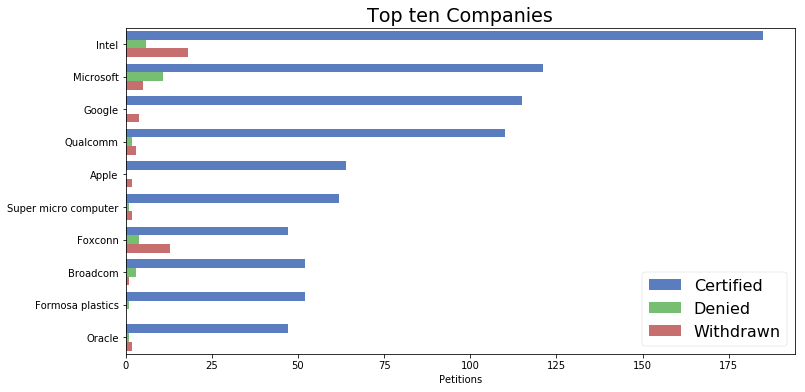

In [13]:
top_c = perm.Employer.value_counts().sort_values(ascending=False).head(10).index
f, ax = plt.subplots(figsize=(12, 6))

sns.countplot(y="Employer",
              hue='Status',
              data=perm.loc[perm.Employer.isin(top_c)],
              order = top_c,
              ax = ax
             );
sns.set_context("poster")
plt.legend(loc=4)
ax.set(title='Top ten Companies', ylabel='', xlabel='Petitions');

### And the top ten States:

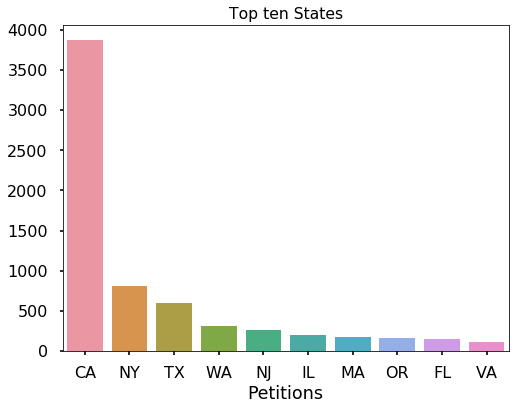

In [14]:
top_s = perm.State.value_counts().sort_values(ascending=False).head(10).index
f, ax = plt.subplots(figsize=(8, 6))

sns.countplot(x="State",
              data=perm.loc[(perm.State.isin(top_s)) & (perm.Status=='Certified')],
              order = top_s,
              ax = ax
             );
sns.set_context("talk")
ax.set(title='Top ten States', ylabel='', xlabel='Petitions');

#### Seems like most of the cases are from California, find out the percentage:

In [15]:
state_names = pd.read_csv('State_list.csv', names=['post','State'], index_col='post')
state_count = perm.State.value_counts().to_frame(name='Count')
state_count['Percent'] = 100*(state_count['Count']/perm.State.value_counts().sum())
state_count = pd.concat([state_count, state_names], axis=1)
state_count[['State', 'Count', 'Percent']].sort_values(by='Count',ascending=False)\
                                          .reset_index(drop=True)                 \
                                          .round(2)                               \
                                          .head(10)

,State,Count,Percent
0,California,4313,48.06
1,New York,937,10.44
2,Texas,667,7.43
3,Washington,348,3.88
4,New Jersey,303,3.38
5,Illinois,232,2.58
6,Massachusetts,201,2.24
7,Oregon,183,2.04
8,Florida,173,1.93
9,Virginia,133,1.48


#### Nearly 60% of the cases are from California and New York, look into case status by the most two popular areas:

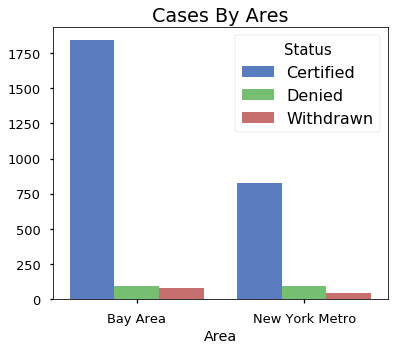

In [16]:
f, ax = plt.subplots(figsize=(6, 5))
sns.set_context("poster")
sns.countplot(data=perm, x='Area', hue='Status');
ax.set(title='Cases By Ares', ylabel='');

#### Within approved cases in these two areas, what's the most populat job categories?

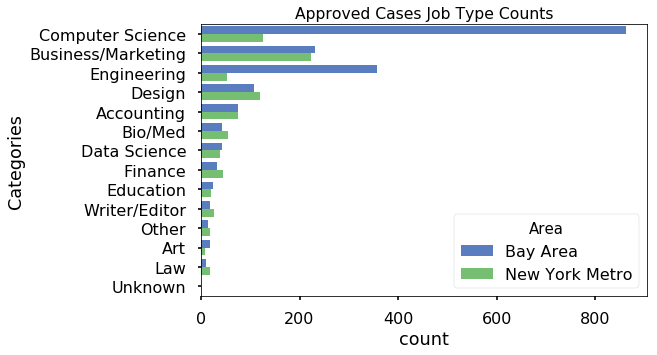

In [17]:
f, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=perm.loc[perm.Status=='Certified'],
              y="Cat",
              hue='Area',
              order = perm.loc[perm.Area.notnull(),'Cat'].value_counts().index,
              ax = ax);
sns.set_context("talk")
ax.set(title='Approved Cases Job Type Counts', ylabel='Categories');

#### C.S. dominate the approved cases

---
## Salary
#### descriptive statistics 

In [18]:
perm.groupby('Status')[['Salary']].agg(['mean','median','std', 'min', 'max']).round(2)

Salary                                      
               mean   median       std      min       max
Status                                                   
Certified  75143.40  71292.0  30191.26  14726.0  315000.0
Denied     65781.55  60541.3  27445.41  12708.8  230000.0
Withdrawn  72603.74  68931.0  31842.28  12000.0  240000.0

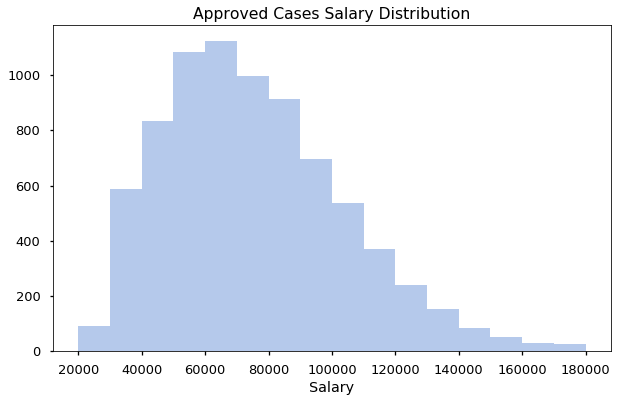

In [19]:
f, ax = plt.subplots(figsize=(10, 6))
sns.distplot(perm.loc[perm.Status=='Certified', 'Salary'],
             kde=False,
             bins=list(range(20000,190000,10000)))
ax.set(title='Approved Cases Salary Distribution');

## What about regional differences?

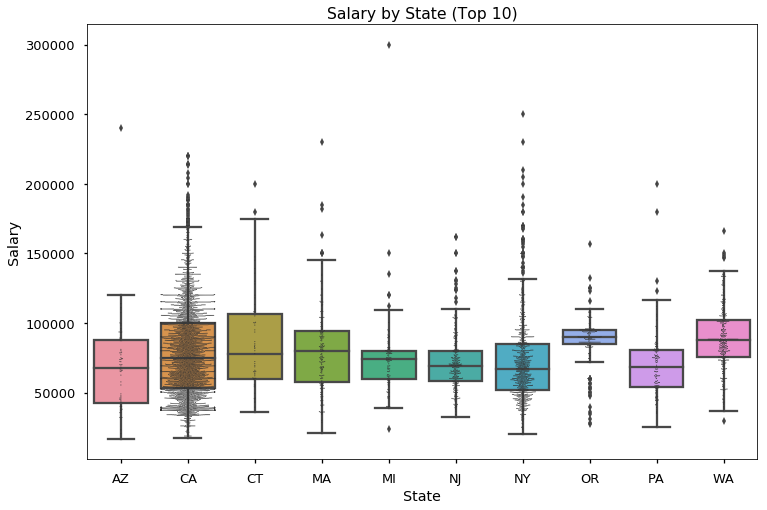

In [20]:
# not rare states
not_rare = perm.loc[perm.State.isin(perm.State.value_counts()[(perm.State.value_counts()>20)].index)].copy()
# top median
top_median = not_rare.groupby(['State'])['Salary'].agg('median').sort_values(ascending=False).head(10).index

top_df = perm.loc[perm.State.isin(top_median)].copy()
top_df.State = top_df.State.astype('object').astype('category')

f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x="State",
            y="Salary",
            data=top_df);
sns.swarmplot(x="State", 
              y="Salary", 
              data=top_df,
              size=1, 
              color=".2", 
              linewidth=0)
ax.set(title='Salary by State (Top 10)');

In [21]:
# ANOVA breakdown of Salary by States
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import statsmodels.api as smt
from statsmodels.formula.api import ols

model=ols('Salary ~ C(State)', data=top_df).fit()
print(smt.stats.anova_lm(model, typ=2))

                sum_sq      df          F        PR(>F)
C(State)  1.263952e+11     9.0  15.683084  1.164880e-25
Residual  5.956743e+12  6652.0        NaN           NaN


In these results, the null hypothesis states that the mean salary of 10 different states are equal. Because the p-value is less than the significance level of 0.01, we can reject the null hypothesis and conclude that some of the states have different average salary.

#### Differences between Bay area and New York Metro area:

In [22]:
perm.loc[perm.Status=='Certified'].groupby('Area')[['Salary']].agg(['mean','median','std', 'min', 'max']).round(2)

Salary                                     
                    mean   median      std      min       max
Area                                                         
Bay Area        95694.40  95631.5  29578.1  17014.4  220251.0
New York Metro  73077.64  67340.0  29434.8  23483.0  250000.0

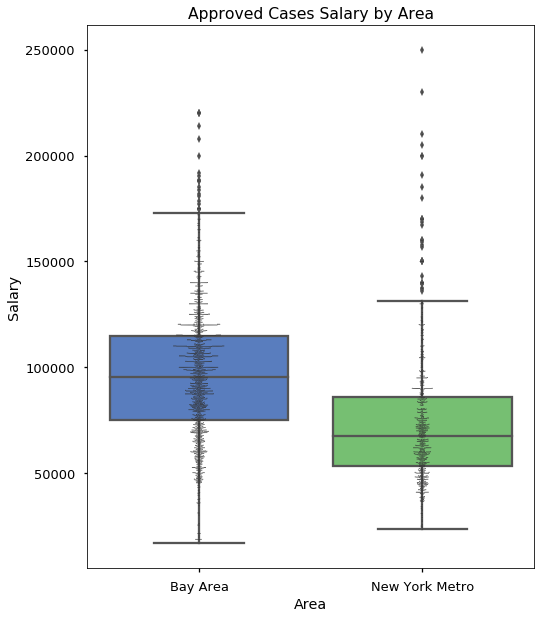

In [23]:
f, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="Area",
            y="Salary",
            data=perm.loc[perm.Status=='Certified']);
sns.swarmplot(x="Area", 
              y="Salary", 
              data=perm.loc[perm.Status=='Certified'],
              size=1, 
              color=".2", 
              linewidth=0)
ax.set(title='Approved Cases Salary by Area');

In [24]:
# Two-sample t-test for average salary in bay area and new york metro area:
from scipy.stats import ttest_ind

bay = perm.loc[(perm.Status=='Certified') & (perm.Area == 'Bay Area')]
nym = perm.loc[(perm.Status=='Certified') & (perm.Area == 'New York Metro')] 

results = ttest_ind(bay.Salary, nym.Salary)
print('t-statistic: ' + str(results[0]))
print('p-value: ' + str(results[1]))

t-statistic: 18.2996811794
p-value: 1.45658653945e-70


In this result, the null hypothesis states that the mean salary of two areas are equal. Because the p-value is less than the significance level of 0.01, we can reject the null hypothesis and conclude that the average salary in Bay area is significantly higher than New York Metro area.

#### Differences between job levels:

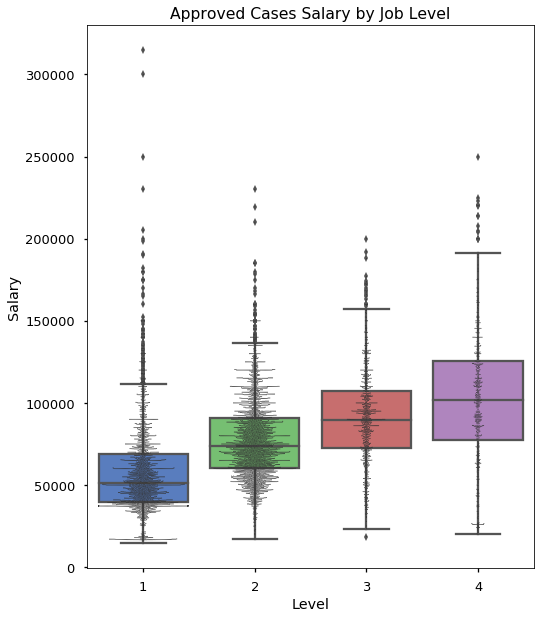

In [25]:
f, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="Level",
            y="Salary",
            order = ['1','2','3','4'],
            data=perm.loc[perm.Status=='Certified']);
sns.swarmplot(x="Level", 
              y="Salary",
              order = ['1','2','3','4'], 
              data=perm.loc[perm.Status=='Certified'],
              size=1, 
              color=".2", 
              linewidth=0)
ax.set(title='Approved Cases Salary by Job Level');

In [26]:
# ANOVA breakdown of Salary by job levels

model=ols('Salary ~ C(Level)', data=top_df).fit()
print(smt.stats.anova_lm(model, typ=2))

                sum_sq      df           F  PR(>F)
C(Level)  1.223778e+12     3.0  570.143529     0.0
Residual  4.490351e+12  6276.0         NaN     NaN


In these results, the null hypothesis states that the mean salary of 4 different job level are equal. Because the p-value is less than the significance level of 0.01, we can reject the null hypothesis and conclude that average salary difference between job levels is statistical significant.

#### Differences between job levels and areas:

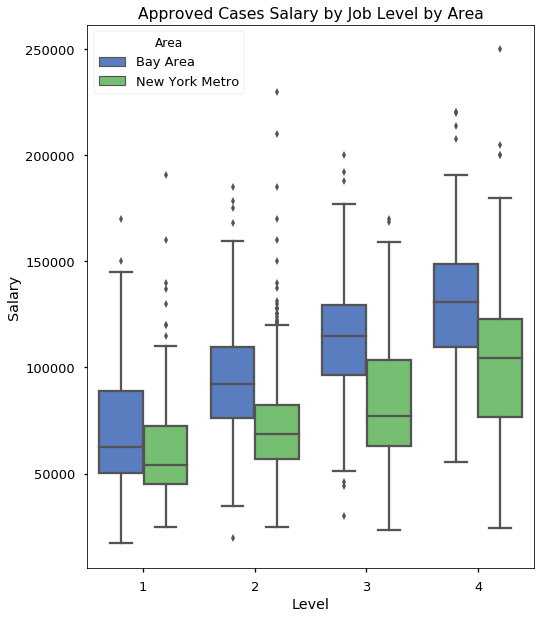

In [27]:
f, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="Level",
            y="Salary",
            hue='Area',
            order = ['1','2','3','4'],
            data=perm.loc[perm.Status=='Certified']);
ax.set(title='Approved Cases Salary by Job Level by Area');

In [28]:
# ANOVA breakdown of Salary by Level and area

model=ols('Salary ~ C(Level) + C(Area)', data=perm.loc[perm.Status=='Certified']).fit()
print(smt.stats.anova_lm(model, typ=2))

                sum_sq      df           F         PR(>F)
C(Level)  4.975960e+11     3.0  235.906884  1.773966e-134
C(Area)   2.052291e+11     1.0  291.893212   6.379670e-62
Residual  1.724696e+12  2453.0         NaN            NaN


In these results, the null hypothesis states that the mean salary between different job level and Area are equal. Because the p-value is less than the significance level of 0.01, we can reject the null hypothesis and conclude that average salary difference between job levels and areas is statistical significant.

#### Differences between job levels and case status:

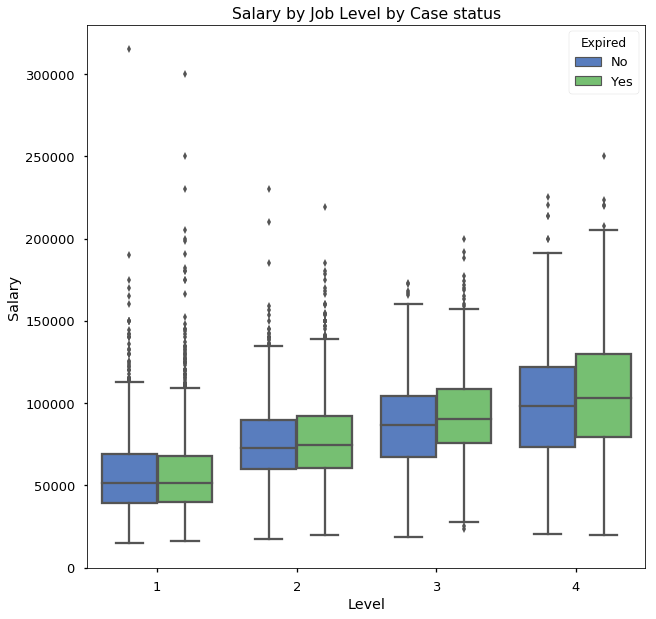

In [29]:
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="Level",
            y="Salary",
            hue='Expired',
            order = ['1','2','3','4'],
            data=perm.loc[perm.Status=='Certified']);
ax.set(title='Salary by Job Level by Case status');

In [30]:
# ANOVA breakdown of Salary by Level and Expiration

model=ols('Salary ~ C(Level) + C(Expired)', data=perm.loc[perm.Status=='Certified']).fit()
print(smt.stats.anova_lm(model, typ=2))

                  sum_sq      df           F    PR(>F)
C(Level)    1.373687e+12     3.0  632.582116  0.000000
C(Expired)  3.743197e+09     1.0    5.171221  0.022992
Residual    5.500550e+12  7599.0         NaN       NaN


In these results, because of the p-value of 'Level' is less than the significance level of 0.01, and the p-value of 'Expired' is geater than the significance level of 0.01, we can conclude that the average salary difference between job levels is statistical significant, but not between expiration status.

---
## Salary Trend

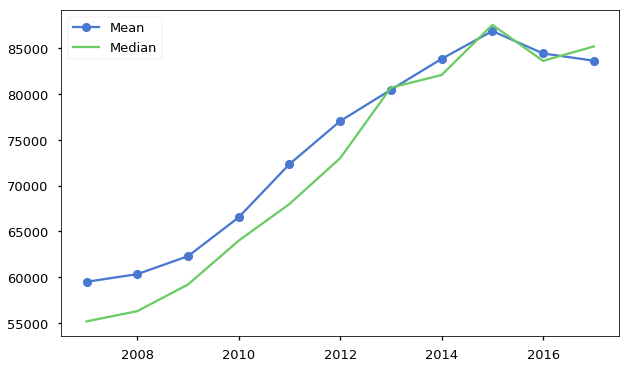

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(perm.loc[perm.Status=='Certified'].groupby(perm.Date.dt.year)['Salary']
         .agg(['mean']), marker='o', label='Mean')
plt.plot(perm.loc[perm.Status=='Certified'].groupby(perm.Date.dt.year)['Salary']
         .agg(['median']), label='Median')
plt.legend();

#### Salary trend by area

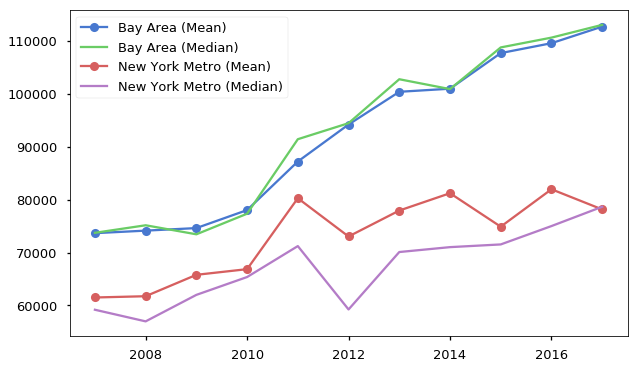

In [32]:
plt.figure(figsize=(10, 6))
perm_cer = perm.loc[perm.Status=='Certified']  
data = perm_cer.groupby([perm_cer.Date.dt.year, perm_cer.Area])['Salary'].agg(['mean','median']).unstack(level=-1)
plt.plot(data['mean']['Bay Area'], marker='o', label='Bay Area (Mean)')
plt.plot(data['median']['Bay Area'], label='Bay Area (Median)')
plt.plot(data['mean']['New York Metro'], marker='o', label='New York Metro (Mean)')
plt.plot(data['median']['New York Metro'], label='New York Metro (Median)')
plt.legend();